# Time Series Anomaly Detection by Image Classification

## Preface

One of my day jobs working in a IC design house is to help our sensor be well manufactured through the process. Root-causing every manufacture failure from the factory is one the important thing in the process, so this is where early detection of unusual behavior is system or business metrics comes in. 

## Imports

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [ ]:
plt.style.use(['dark_background'])

## Paths

In [ ]:
DATA_PATH = Config.data_path()
PATH = DATA_PATH/'anomaly'
PATH.ls()

[PosixPath('/home/jupyter/.fastai/data/anomaly/anomaly'),
 PosixPath('/home/jupyter/.fastai/data/anomaly/normal'),
 PosixPath('/home/jupyter/.fastai/data/anomaly/models')]

## Data Preparation

The time series dataset could include a variety of distinct problem domains such as cloud service request rates, product purchase counts, application crash rates, and API latencies. The dataset is annotated with anomalies - that is, time slices where experts have indicated that they want to be notified to investigate for possible issues. The dataset contains over 100 distinct anomalies.

The default behavior of `fast.ai` is to crop images, which I don't think it will work well because I don't want any part of the continuous signal to be cropped unexpectedly. My first gut feelings is not to rotate or flip the images, but maybe it is an experiment that worth giving it a shot because some abnormal spike in positive direction might happen in negative direction, perhaps, not sure, so I might need to consult with domain expert on this assumptions. 

In [ ]:
tfms = get_transforms(do_flip=False, max_zoom=1)

In [ ]:
src = (ImageItemList.from_folder(PATH)
       .random_split_by_pct()
       .label_from_folder())

In [ ]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (508 items)
[Category anomaly, Category anomaly, Category anomaly, Category anomaly, Category anomaly]...
Path: /home/jupyter/.fastai/data/anomaly
x: ImageItemList (508 items)
[Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224)]...
Path: /home/jupyter/.fastai/data/anomaly;

Valid: LabelList
y: CategoryList (126 items)
[Category anomaly, Category normal, Category normal, Category anomaly, Category normal]...
Path: /home/jupyter/.fastai/data/anomaly
x: ImageItemList (126 items)
[Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224)]...
Path: /home/jupyter/.fastai/data/anomaly;

Test: None

### Sanity Check

In [ ]:
data.sanity_check()

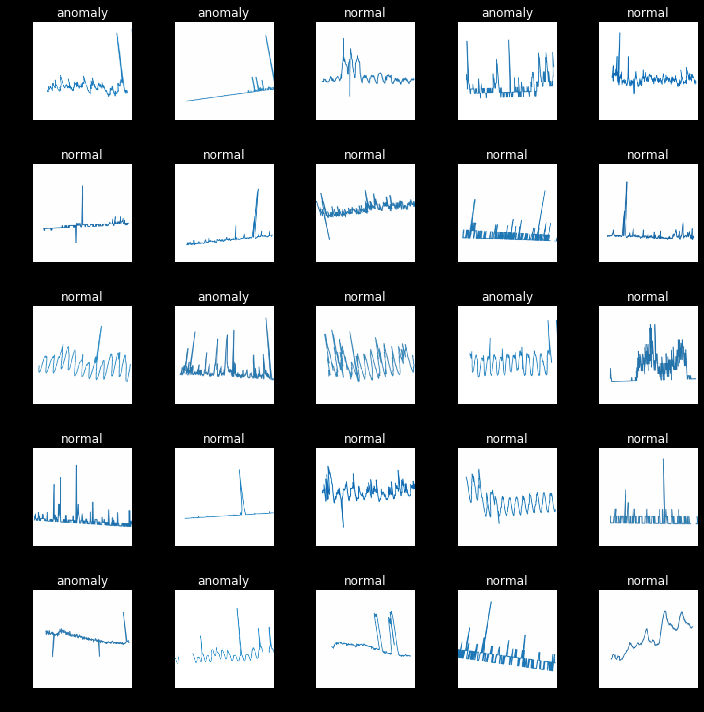

In [ ]:
data.show_batch(rows=5, figsize=(10,10))

## Train

Now we will train a model using [resnet34](https://arxiv.org/pdf/1512.03385.pdf) as our backbone.

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


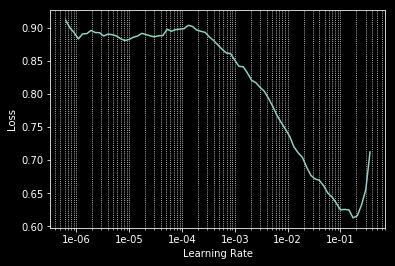

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,error_rate
1,0.761952,0.543574,0.246032
2,0.641019,0.687787,0.230159
3,0.522876,1.246816,0.246032
4,0.457442,0.530232,0.246032
5,0.423848,0.225621,0.071429
6,0.370040,0.232729,0.079365
7,0.335567,0.172647,0.055556
8,0.308068,0.158665,0.063492
9,0.287806,0.152856,0.063492
10,0.263615,0.147765,0.071429


In [ ]:
learn.save('stage-1')

The training loss, 0.263, is greater than valid loss, meaning it is underfitting, so let's do more epochs

In [ ]:
learn.load('stage-1');

In [ ]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,error_rate
1,0.144430,0.142429,0.063492
2,0.140668,0.148644,0.071429
3,0.141895,0.145252,0.063492
4,0.137131,0.219978,0.071429
5,0.135576,0.366054,0.111111
6,0.145547,0.184181,0.063492
7,0.161606,0.201384,0.087302
8,0.178614,0.217608,0.063492
9,0.179613,0.271347,0.126984
10,0.172334,0.156603,0.063492


In [ ]:
learn.save('stage-2')

Amazingly, even before I `unfreeze` the low-level layers, we got error rate of 3.17%! This is somewhat surprising because we mixed up different metric domains.

## Interpretation

Let's visualize what results we have got. Noramlly, at this stage, I will invite the domain expert to join the disscussion, so 1.) they can learn more about the signal from this iteration and 2.) I can learn more understanding about the data and see if there is any further measure that I can take to improve. 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

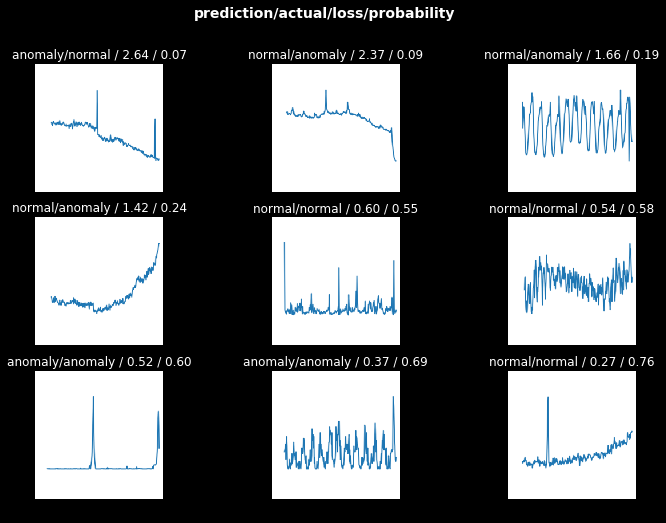

In [ ]:
interp.plot_top_losses(9, figsize=(12,8))

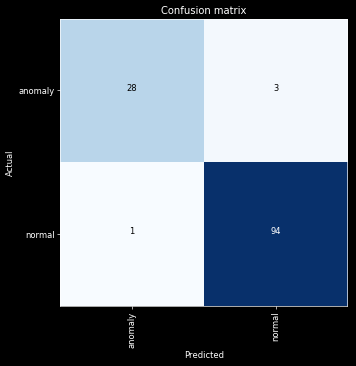

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

## Fine-tune

Let's `unfreeze` the lower level layers and train some more and see if it improves.

In [ ]:
learn.load('stage-2');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


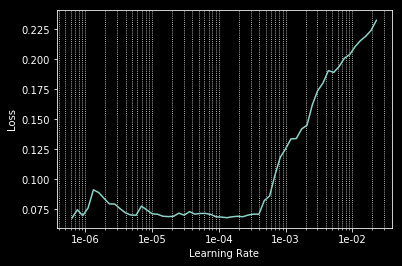

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
learn.fit_one_cycle(10, slice(1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.081575,0.092502,0.039683
2,0.071382,0.092599,0.039683
3,0.058237,0.094887,0.039683
4,0.052389,0.082674,0.031746
5,0.052574,0.085728,0.031746
6,0.060251,0.093697,0.039683
7,0.059458,0.097919,0.031746
8,0.061505,0.098460,0.039683
9,0.062167,0.104274,0.039683
10,0.061280,0.102488,0.039683


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

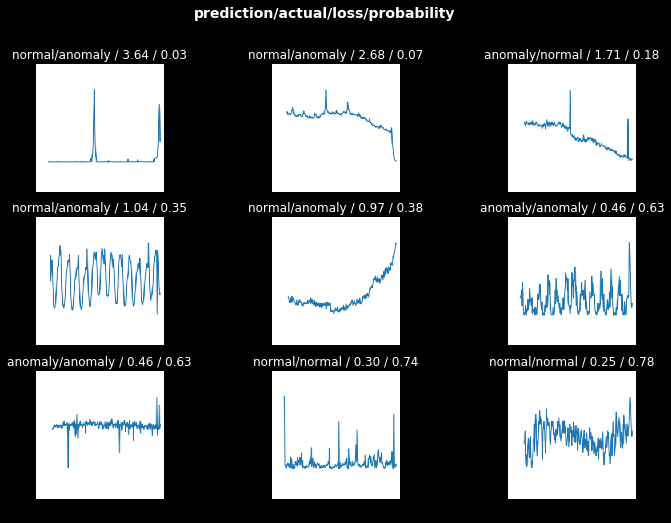

In [ ]:
interp.plot_top_losses(9, figsize=(12,8))

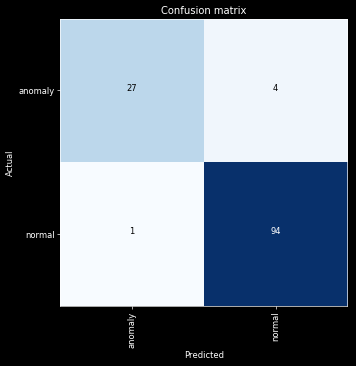

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

It seems our fine-tune process doesn't help much on the accuracy, maybe our training is not enough for fine-tuning the low level feature layers.

![](tmp/ts2anomaly_losses.jpg)

From the plots above, we see three of the `top_losses` are improved by 35% through the fine-tune process and two are getting worse.

## EON